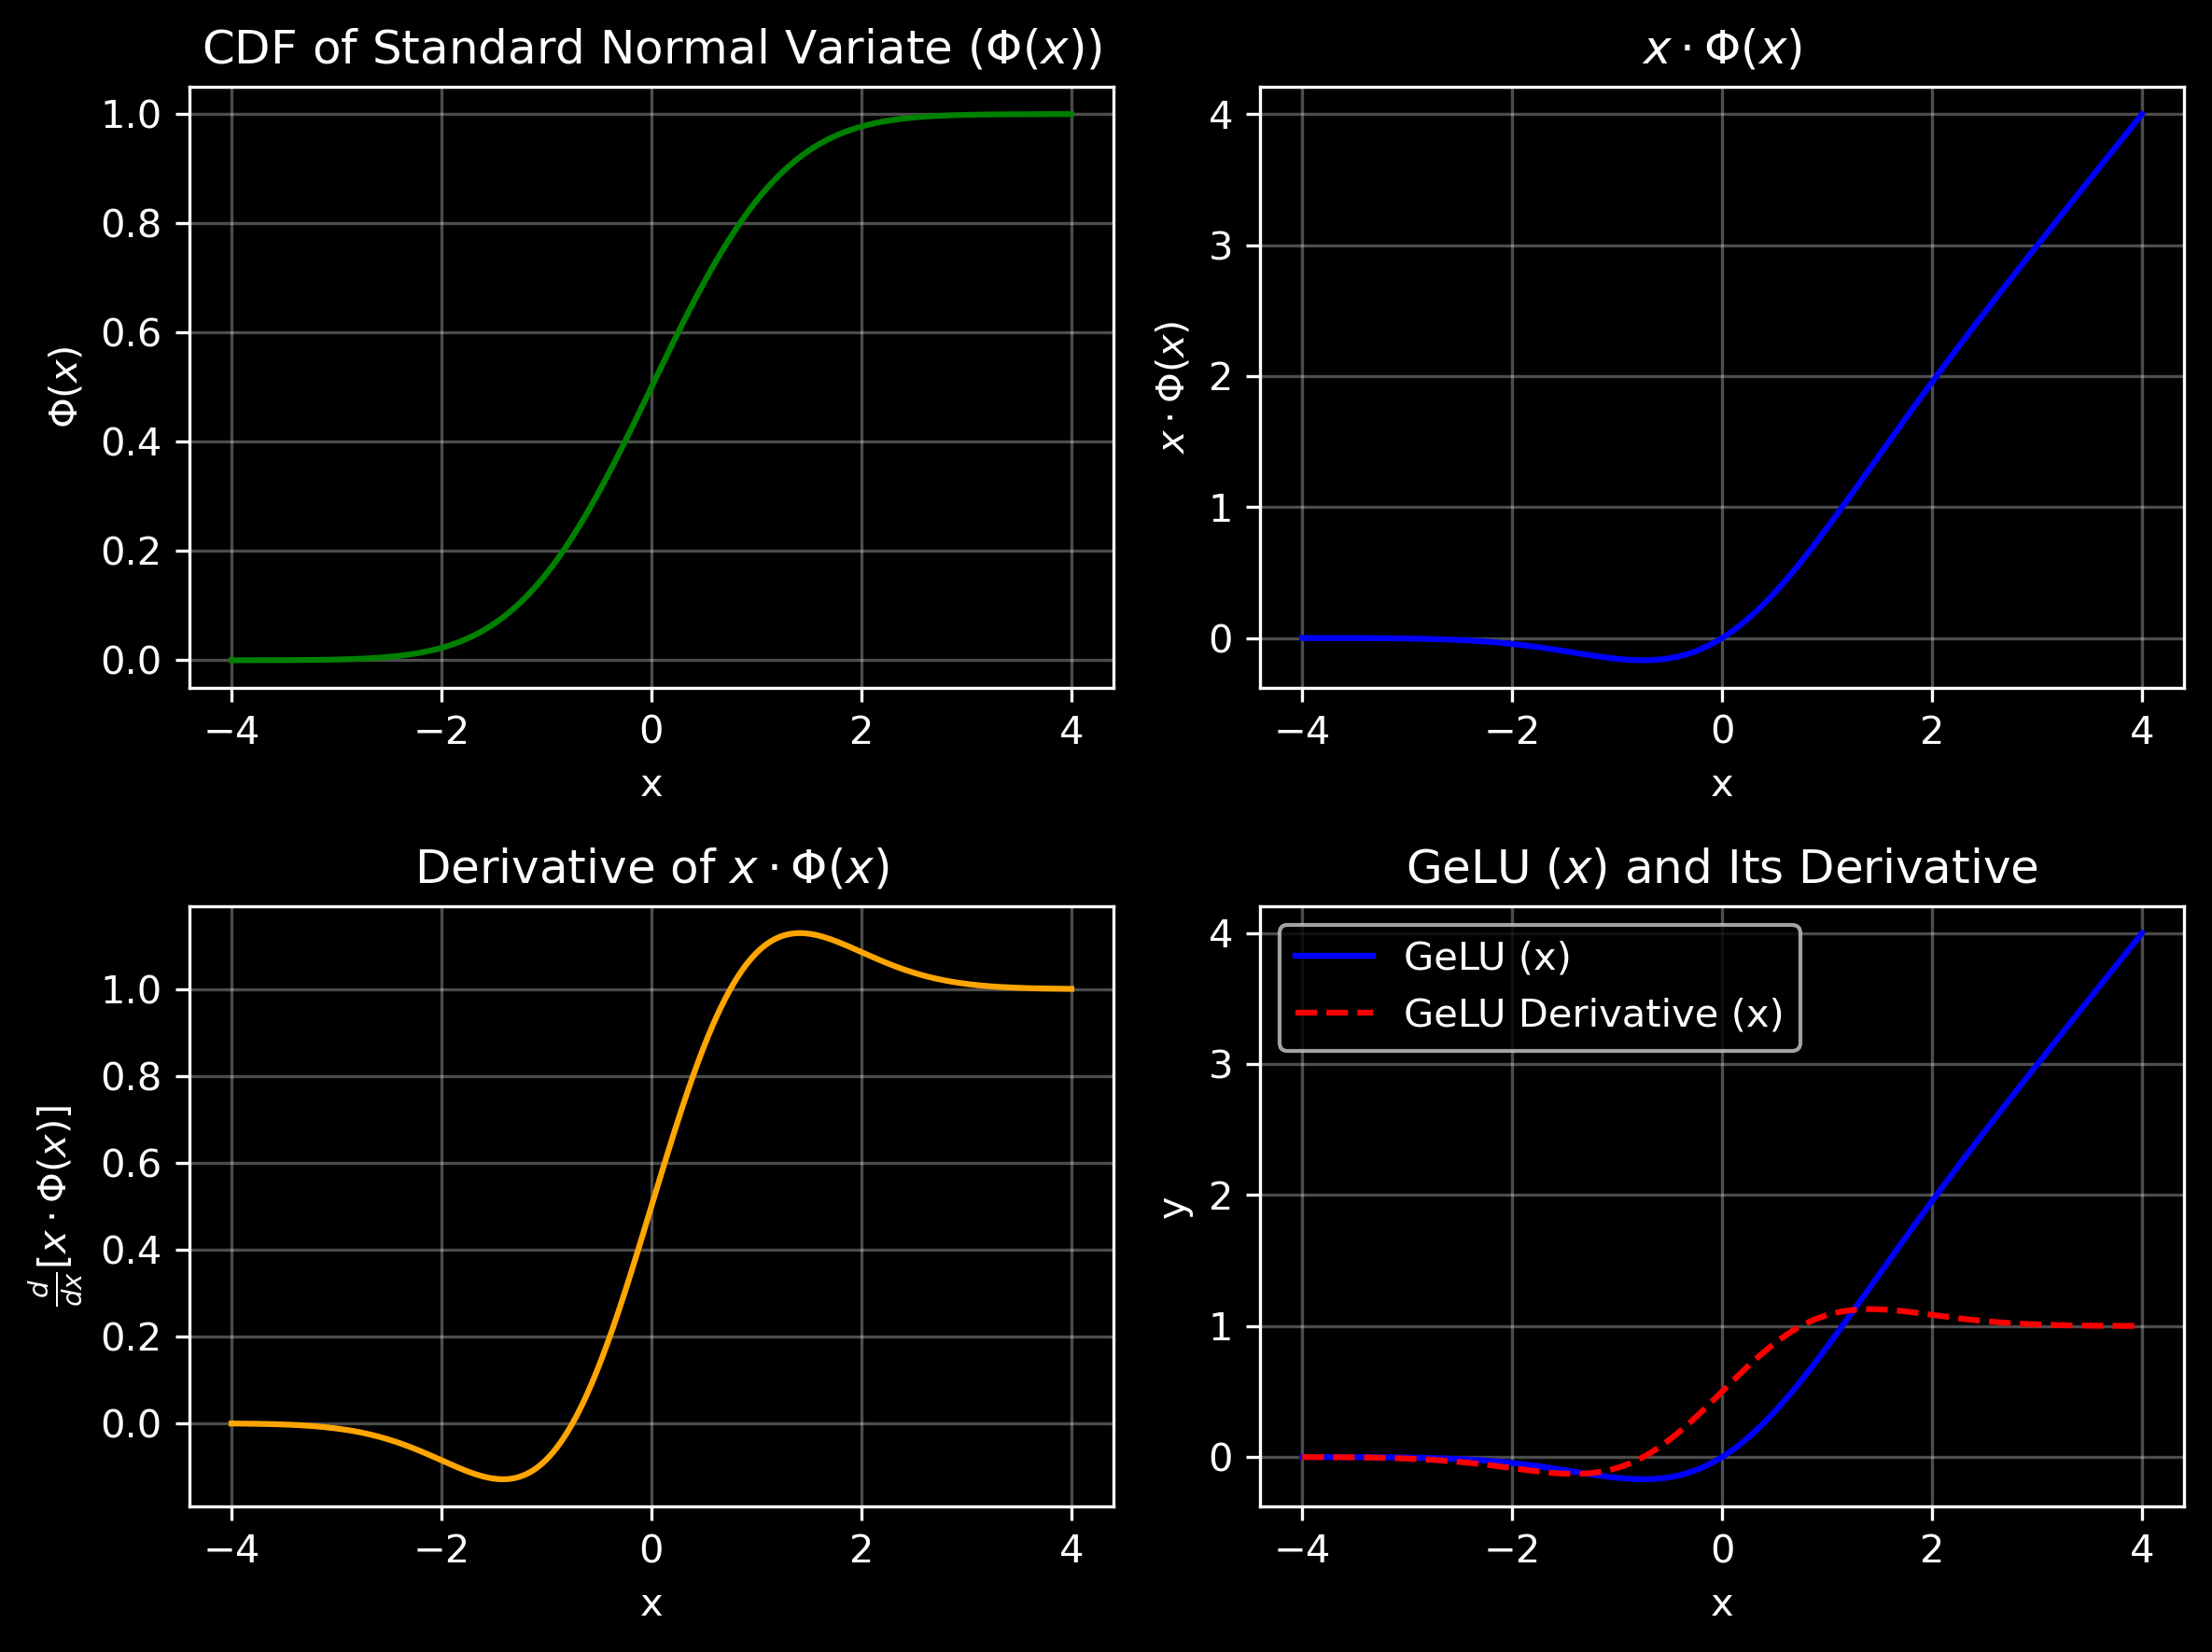

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(47)
plt.style.use('dark_background')

# Define the range and standard normal CDF
x = torch.linspace(-4, 4, 500, requires_grad=True)
phi_x = 0.5 * (1 + torch.erf(x / torch.sqrt(torch.tensor(2.0))))  # CDF of x

# Compute GeLU using PyTorch's built-in function
x_input = torch.linspace(-4, 4, 500, requires_grad=True)
gelu_x = F.gelu(x_input)

# Compute the gradient (derivative) of GeLU
gelu_x.backward(torch.ones_like(x_input))
gelu_x_derivative = x_input.grad.clone()

# Compute x * Phi(x) and its derivative
x_cdf = x * phi_x
x_cdf.backward(torch.ones_like(x))
x_cdf_derivative = x.grad.clone()

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(8, 6), dpi=300)

# Plot 1: CDF of Standard Normal Variate (Phi(x))
axs[0, 0].plot(x.detach().numpy(), phi_x.detach().numpy(), color='green')
axs[0, 0].set_title(r"CDF of Standard Normal Variate ($\Phi(x)$)")
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel(r"$\Phi(x)$")
axs[0, 0].grid(alpha=0.3)

# Plot 2: x * Phi(x)
axs[0, 1].plot(x.detach().numpy(), x_cdf.detach().numpy(), color='blue')
axs[0, 1].set_title(r"$x \cdot \Phi(x)$")
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel(r"$x \cdot \Phi(x)$")
axs[0, 1].grid(alpha=0.3)

# Plot 3: Derivative of x * Phi(x)
axs[1, 0].plot(x.detach().numpy(), x_cdf_derivative.detach().numpy(), color='orange')
axs[1, 0].set_title(r"Derivative of $x \cdot \Phi(x)$")
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel(r"$\frac{d}{dx} \left[ x \cdot \Phi(x) \right]$")
axs[1, 0].grid(alpha=0.3)

# Plot 4: GeLU and Its Derivative (using x_input)
axs[1, 1].plot(x_input.detach().numpy(), gelu_x.detach().numpy(), label="GeLU (x)", color='blue')
axs[1, 1].plot(x_input.detach().numpy(), gelu_x_derivative.detach().numpy(), label="GeLU Derivative (x)", color='red', linestyle='--')
axs[1, 1].set_title(r"GeLU ($x$) and Its Derivative")
axs[1, 1].set_xlabel("x")
axs[1, 1].set_ylabel("y")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

#### Intuition Behind GeLU

In GeLU, the output is $x \Phi(x)$, where $\Phi(x)$ is the cumulative distribution function (CDF) of the standard normal distribution. This combines $x$ with a probabilistic weighting based on its magnitude and sign, as determined by the CDF.

##### Key Interactions:

- **Large positive $x$**:  
  $\Phi(x) \approx 1$, so $x$ is kept almost as-is. These values are important and should be retained.

- **Small positive $x$**:  
  $\Phi(x) < 1$, so $x$ is scaled down. These values are less critical but still contribute.

- **Large negative $x$**:  
  $\Phi(x) \approx 0$, so $x$ is suppressed to reduce large negative contributions, helping to prevent destabilizing large negative summations in the overall output.

- **Near-zero $x$**:  
  The function smoothly transitions, ensuring differentiability and avoiding sharp cuts like ReLU.

**Note**: GeLU is a deterministic function. There is no random sampling happening. The key idea is that input values are modulated according to their magnitude and sign, using the cumulative distribution function (CDF) of the standard normal distribution.

# GeLU vs Common Activation Functions

## 1. Problems with ReLU

### a. Non-differentiability at $ x = 0 $
- **ReLU**: Sharp transition at $ x = 0 $, causing non-differentiability and potential unstable gradients.
- **GeLU Fix**: GeLU is smooth and differentiable everywhere, allowing stable gradient flow and better convergence.

### b. Dead Neurons
- **ReLU**: Negative outputs are set to zero, potentially leading to neurons that never activate again if their gradients vanish.
- **GeLU Fix**: GeLU modulates negative values rather than zeroing them out, retaining some learning ability for negative inputs.

### c. Harsh Transitions
- **ReLU**: Hard cutoff at $ x = 0 $, causing instability when inputs oscillate near this threshold.
- **GeLU Fix**: GeLU’s smooth probabilistic weighting ensures stable transitions and smoother learning dynamics.

## 2. Problems with Sigmoid

### a. Vanishing Gradients for Large Inputs
- **Sigmoid**: For large or small inputs, sigmoid gradients approach zero, slowing down learning.
- **GeLU Fix**: GeLU grows linearly for large positive inputs, avoiding saturation and keeping gradients alive. It also smoothly suppresses negative inputs without full saturation.

### b. Non-zero Mean Outputs
- **Sigmoid**: Outputs between 0 and 1, causing bias in activations, slowing convergence.
- **GeLU Fix**: GeLU produces approximately zero-centered outputs, reducing bias and speeding up convergence.

## 3. Problems with Tanh

### a. Vanishing Gradients for Extreme Inputs
- **Tanh**: Saturates for large positive or negative inputs, leading to vanishing gradients.
- **GeLU Fix**: GeLU grows linearly for large positive inputs and suppresses large negative inputs smoothly without full saturation.

### b. Computational Complexity
- **Tanh**: Higher computational cost compared to simpler functions like ReLU.
- **GeLU Fix**: GeLU approximations (e.g., using the error function or Taylor expansions) allow it to maintain competitive computational efficiency.

## 4. Problems with Leaky ReLU

### a. Non-differentiability at $ x = 0 $
- **Leaky ReLU**: Still has a non-differentiable point at $ x = 0 $.
- **GeLU Fix**: Fully differentiable across all input values, making it smoother and more gradient-friendly.

### b. Arbitrary Slope for Negative Inputs
- **Leaky ReLU**: Uses a fixed slope (usually 0.01) for negative inputs, which may not be optimal.
- **GeLU Fix**: Dynamically scales negative inputs based on $ \Phi(x) $, adjusting the slope probabilistically.

## 5. Complication with Swish

### a. Additional Learnable Parameter 
- **Swish**: Often includes a learnable parameter $ \beta $ to control the activation's shape, adding complexity. Might lead to overfitting. 

## 6. General Problems in Activation Functions

### a. Saturation
- **Common Activations**: Many functions saturate for extreme inputs, leading to either fixed output limits (sigmoid, tanh) or nullification (ReLU for negatives).
- **GeLU Fix**: GeLU avoids full saturation:
  - For large positive inputs: $ x \Phi(x) \approx x $, ensuring linear behavior.
  - For large negative inputs: $ x \Phi(x) \approx 0 $, smoothly suppressing the output.

### b. Lack of Smooth Transitions
- **Common Activations**: Sharp transitions (e.g., ReLU) cause instability and optimization issues.
- **GeLU Fix**: GeLU provides smooth transitions everywhere, especially around $ x = 0 $, where other functions struggle.

## Summary of GeLU Advantages
- Fully differentiable with smooth transitions.
- Avoids dead neurons by probabilistically scaling negative inputs.
- Prevents vanishing gradients by maintaining non-saturating behavior.
- Outputs are approximately zero-centered, reducing bias.
- No additional parameters or hyperparameters required.
